Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)         2

184/184 [==============================] - 105s 569ms/step - loss: 0.3415 - accuracy: 0.8930 - val_loss: 0.4339 - val_accuracy: 0.9024
Epoch 4/75
184/184 [==============================] - 108s 587ms/step - loss: 0.3414 - accuracy: 0.8917 - val_loss: 0.4248 - val_accuracy: 0.9085
Epoch 5/75
184/184 [==============================] - 105s 569ms/step - loss: 0.3142 - accuracy: 0.9000 - val_loss: 0.4228 - val_accuracy: 0.9065
Epoch 6/75
184/184 [==============================] - 106s 577ms/step - loss: 0.3161 - accuracy: 0.9027 - val_loss: 0.4235 - val_accuracy: 0.9045
Epoch 7/75
184/184 [==============================] - 105s 570ms/step - loss: 0.3076 - accuracy: 0.9076 - val_loss: 0.4219 - val_accuracy: 0.9079
Epoch 8/75
184/184 [==============================] - 104s 567ms/step - loss: 0.2815 - accuracy: 0.9125 - val_loss: 0.3934 - val_accuracy: 0.9099
Epoch 9/75
184/184 [==============================] - 104s 567ms/step - loss: 0.2835 - accuracy: 0.9076 - val_loss: 0.3829 - val_accura

Epoch 59/75
184/184 [==============================] - 105s 570ms/step - loss: 0.0553 - accuracy: 0.9860 - val_loss: 0.2749 - val_accuracy: 0.9350
Epoch 60/75
184/184 [==============================] - 105s 571ms/step - loss: 0.0531 - accuracy: 0.9866 - val_loss: 0.2804 - val_accuracy: 0.9336
Epoch 61/75
184/184 [==============================] - 106s 575ms/step - loss: 0.0474 - accuracy: 0.9863 - val_loss: 0.3048 - val_accuracy: 0.9262
Epoch 62/75
184/184 [==============================] - 105s 571ms/step - loss: 0.0505 - accuracy: 0.9902 - val_loss: 0.2899 - val_accuracy: 0.9350
Epoch 63/75
184/184 [==============================] - 106s 578ms/step - loss: 0.0564 - accuracy: 0.9869 - val_loss: 0.2982 - val_accuracy: 0.9248
Epoch 64/75
184/184 [==============================] - 105s 573ms/step - loss: 0.0462 - accuracy: 0.9886 - val_loss: 0.2884 - val_accuracy: 0.9322
Epoch 65/75
184/184 [==============================] - 107s 579ms/step - loss: 0.0429 - accuracy: 0.9893 - val_loss: 0

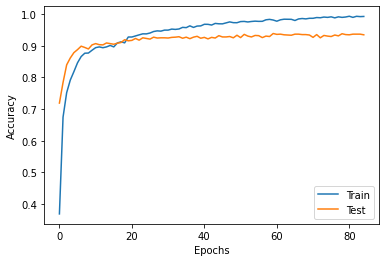

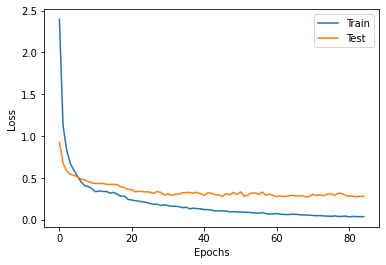

<AxesSubplot:>

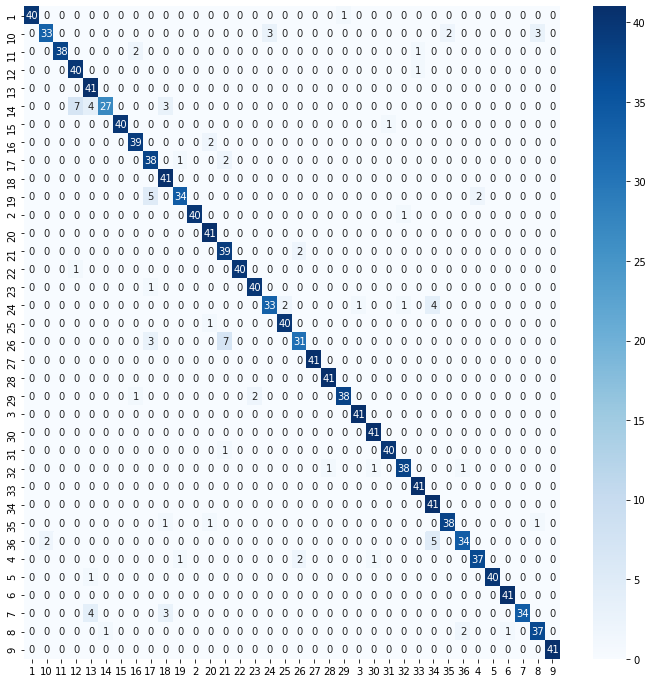

In [1]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 10
epochs2 = 75
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned75

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=13)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=13)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [2]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9384981805360731
recall_score   :  0.9342818428184282
f1_score       :  0.9334819330480086
accuracy_score :  0.9342818428184282

Best accuracy  :  0.9383468627929688


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

184/184 [==============================] - 105s 570ms/step - loss: 0.3358 - accuracy: 0.9012 - val_loss: 0.3776 - val_accuracy: 0.9011
Epoch 4/75
184/184 [==============================] - 105s 569ms/step - loss: 0.3417 - accuracy: 0.8966 - val_loss: 0.3701 - val_accuracy: 0.9045
Epoch 5/75
184/184 [==============================] - 105s 573ms/step - loss: 0.3393 - accuracy: 0.8937 - val_loss: 0.3704 - val_accuracy: 0.9024
Epoch 6/75
184/184 [==============================] - 105s 571ms/step - loss: 0.3159 - accuracy: 0.8997 - val_loss: 0.3801 - val_accuracy: 0.8957
Epoch 7/75
184/184 [==============================] - 105s 569ms/step - loss: 0.3071 - accuracy: 0.9026 - val_loss: 0.3648 - val_accuracy: 0.9031
Epoch 8/75
184/184 [==============================] - 106s 576ms/step - loss: 0.2697 - accuracy: 0.9164 - val_loss: 0.3357 - val_accuracy: 0.9092
Epoch 9/75
184/184 [==============================] - 105s 569ms/step - loss: 0.2653 - accuracy: 0.9166 - val_loss: 0.3371 - val_accura

Epoch 59/75
184/184 [==============================] - 105s 572ms/step - loss: 0.0562 - accuracy: 0.9870 - val_loss: 0.2875 - val_accuracy: 0.9268
Epoch 60/75
184/184 [==============================] - 107s 579ms/step - loss: 0.0524 - accuracy: 0.9869 - val_loss: 0.2720 - val_accuracy: 0.9262
Epoch 61/75
184/184 [==============================] - 105s 570ms/step - loss: 0.0470 - accuracy: 0.9898 - val_loss: 0.2865 - val_accuracy: 0.9329
Epoch 62/75
184/184 [==============================] - 106s 574ms/step - loss: 0.0526 - accuracy: 0.9876 - val_loss: 0.2779 - val_accuracy: 0.9268
Epoch 63/75
184/184 [==============================] - 105s 569ms/step - loss: 0.0552 - accuracy: 0.9871 - val_loss: 0.2586 - val_accuracy: 0.9343
Epoch 64/75
184/184 [==============================] - 105s 570ms/step - loss: 0.0514 - accuracy: 0.9877 - val_loss: 0.2546 - val_accuracy: 0.9397
Epoch 65/75
184/184 [==============================] - 106s 578ms/step - loss: 0.0514 - accuracy: 0.9859 - val_loss: 0

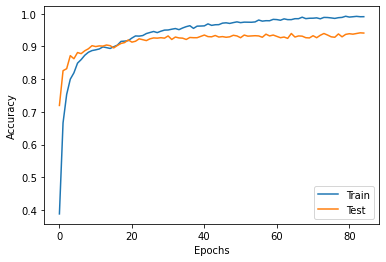

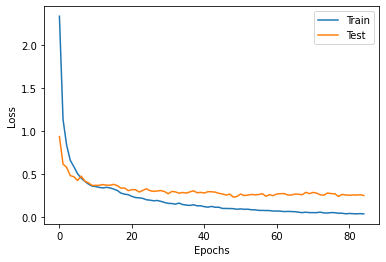

<AxesSubplot:>

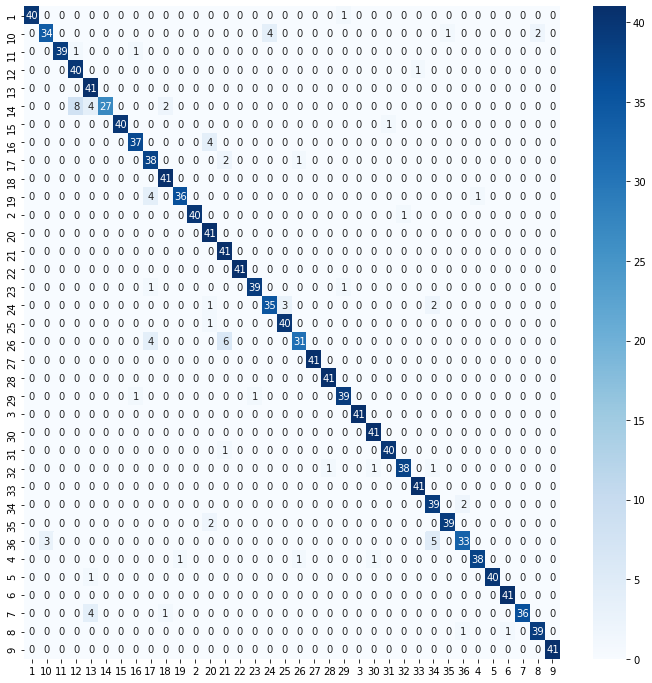

In [3]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 10
epochs2 = 75
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned75

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=14)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=14)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [4]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9457317419656803
recall_score   :  0.9410569105691056
f1_score       :  0.9404988221430423
accuracy_score :  0.9410569105691057

Best accuracy  :  0.9417344331741333


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

184/184 [==============================] - 106s 575ms/step - loss: 0.3027 - accuracy: 0.9070 - val_loss: 0.4414 - val_accuracy: 0.8950
Epoch 4/75
184/184 [==============================] - 107s 583ms/step - loss: 0.3196 - accuracy: 0.8938 - val_loss: 0.4560 - val_accuracy: 0.8923
Epoch 5/75
184/184 [==============================] - 106s 573ms/step - loss: 0.3358 - accuracy: 0.8990 - val_loss: 0.4408 - val_accuracy: 0.8936
Epoch 6/75
184/184 [==============================] - 106s 574ms/step - loss: 0.3251 - accuracy: 0.8942 - val_loss: 0.4194 - val_accuracy: 0.8916
Epoch 7/75
184/184 [==============================] - 106s 577ms/step - loss: 0.2907 - accuracy: 0.9085 - val_loss: 0.3681 - val_accuracy: 0.9024
Epoch 8/75
184/184 [==============================] - 106s 575ms/step - loss: 0.2942 - accuracy: 0.9091 - val_loss: 0.3376 - val_accuracy: 0.8991
Epoch 9/75
184/184 [==============================] - 106s 573ms/step - loss: 0.2550 - accuracy: 0.9187 - val_loss: 0.3614 - val_accura

Epoch 59/75
184/184 [==============================] - 127s 688ms/step - loss: 0.0509 - accuracy: 0.9884 - val_loss: 0.2866 - val_accuracy: 0.9255
Epoch 60/75
184/184 [==============================] - 126s 685ms/step - loss: 0.0552 - accuracy: 0.9880 - val_loss: 0.2739 - val_accuracy: 0.9356
Epoch 61/75
184/184 [==============================] - 121s 659ms/step - loss: 0.0592 - accuracy: 0.9859 - val_loss: 0.3084 - val_accuracy: 0.9234
Epoch 62/75
184/184 [==============================] - 124s 671ms/step - loss: 0.0562 - accuracy: 0.9857 - val_loss: 0.2862 - val_accuracy: 0.9282
Epoch 63/75
184/184 [==============================] - 125s 680ms/step - loss: 0.0574 - accuracy: 0.9841 - val_loss: 0.2827 - val_accuracy: 0.9275
Epoch 64/75
184/184 [==============================] - 122s 662ms/step - loss: 0.0445 - accuracy: 0.9886 - val_loss: 0.2996 - val_accuracy: 0.9248
Epoch 65/75
184/184 [==============================] - 124s 673ms/step - loss: 0.0458 - accuracy: 0.9890 - val_loss: 0

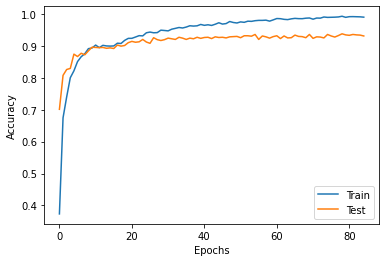

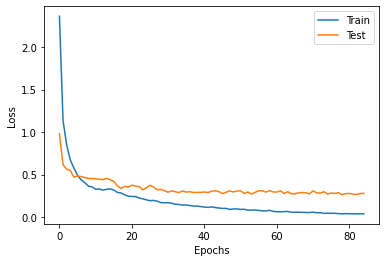

<AxesSubplot:>

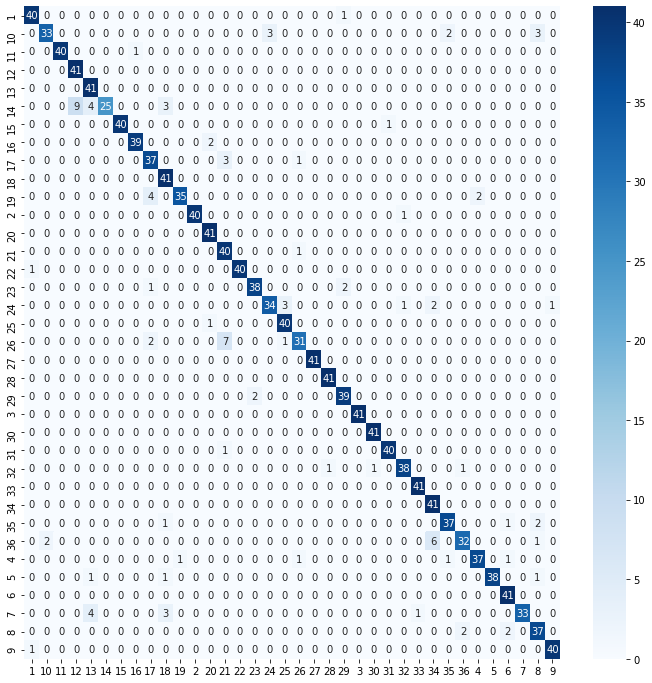

In [5]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 10
epochs2 = 75
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned75

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=15)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=15)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [6]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.936142540880192
recall_score   :  0.9308943089430896
f1_score       :  0.9297638128365535
accuracy_score :  0.9308943089430894

Best accuracy  :  0.9376693964004517


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

184/184 [==============================] - 106s 574ms/step - loss: 0.3274 - accuracy: 0.9001 - val_loss: 0.4665 - val_accuracy: 0.9038
Epoch 4/75
184/184 [==============================] - 105s 573ms/step - loss: 0.3371 - accuracy: 0.8911 - val_loss: 0.4723 - val_accuracy: 0.9018
Epoch 5/75
184/184 [==============================] - 107s 581ms/step - loss: 0.3273 - accuracy: 0.8976 - val_loss: 0.4623 - val_accuracy: 0.9024
Epoch 6/75
184/184 [==============================] - 106s 574ms/step - loss: 0.3125 - accuracy: 0.9008 - val_loss: 0.4472 - val_accuracy: 0.8984
Epoch 7/75
184/184 [==============================] - 106s 575ms/step - loss: 0.3003 - accuracy: 0.9116 - val_loss: 0.4421 - val_accuracy: 0.9079
Epoch 8/75
184/184 [==============================] - 106s 573ms/step - loss: 0.2991 - accuracy: 0.9108 - val_loss: 0.4353 - val_accuracy: 0.9085
Epoch 9/75
184/184 [==============================] - 107s 580ms/step - loss: 0.2675 - accuracy: 0.9121 - val_loss: 0.3865 - val_accura

Epoch 59/75
184/184 [==============================] - 106s 576ms/step - loss: 0.0596 - accuracy: 0.9859 - val_loss: 0.3452 - val_accuracy: 0.9343
Epoch 60/75
184/184 [==============================] - 106s 577ms/step - loss: 0.0491 - accuracy: 0.9876 - val_loss: 0.3609 - val_accuracy: 0.9356
Epoch 61/75
184/184 [==============================] - 107s 579ms/step - loss: 0.0479 - accuracy: 0.9888 - val_loss: 0.3582 - val_accuracy: 0.9322
Epoch 62/75
184/184 [==============================] - 108s 587ms/step - loss: 0.0488 - accuracy: 0.9885 - val_loss: 0.3336 - val_accuracy: 0.9377
Epoch 63/75
184/184 [==============================] - 106s 578ms/step - loss: 0.0517 - accuracy: 0.9899 - val_loss: 0.3096 - val_accuracy: 0.9397
Epoch 64/75
184/184 [==============================] - 110s 597ms/step - loss: 0.0506 - accuracy: 0.9881 - val_loss: 0.3246 - val_accuracy: 0.9350
Epoch 65/75
184/184 [==============================] - 122s 665ms/step - loss: 0.0475 - accuracy: 0.9872 - val_loss: 0

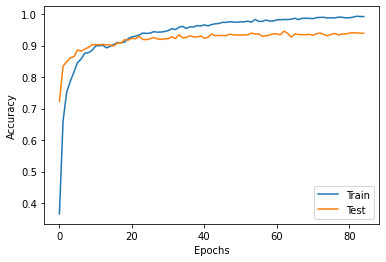

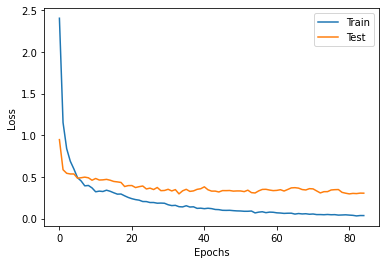

<AxesSubplot:>

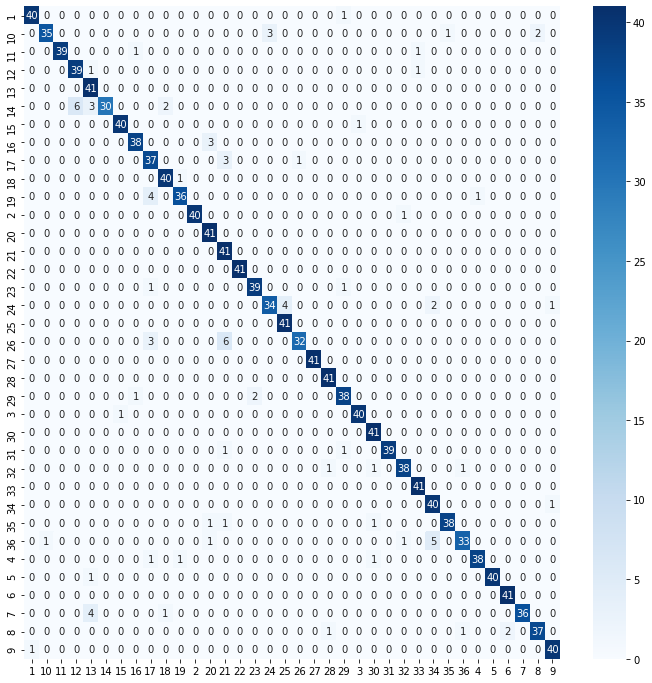

In [7]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 10
epochs2 = 75
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned75

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=16)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=16)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [8]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9433674930422666
recall_score   :  0.9390243902439024
f1_score       :  0.9386783847645093
accuracy_score :  0.9390243902439024

Best accuracy  :  0.9457994699478149


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 8, 8, 256)        

184/184 [==============================] - 125s 680ms/step - loss: 0.3343 - accuracy: 0.8969 - val_loss: 0.5081 - val_accuracy: 0.8950
Epoch 4/75
184/184 [==============================] - 123s 667ms/step - loss: 0.3327 - accuracy: 0.8923 - val_loss: 0.5077 - val_accuracy: 0.8970
Epoch 5/75
184/184 [==============================] - 123s 667ms/step - loss: 0.3348 - accuracy: 0.8993 - val_loss: 0.5073 - val_accuracy: 0.8950
Epoch 6/75
184/184 [==============================] - 127s 689ms/step - loss: 0.3334 - accuracy: 0.8972 - val_loss: 0.4572 - val_accuracy: 0.9119
Epoch 7/75
184/184 [==============================] - 146s 794ms/step - loss: 0.2877 - accuracy: 0.9159 - val_loss: 0.4729 - val_accuracy: 0.9031
Epoch 8/75
184/184 [==============================] - 141s 766ms/step - loss: 0.2815 - accuracy: 0.9127 - val_loss: 0.4724 - val_accuracy: 0.9092
Epoch 9/75
184/184 [==============================] - 155s 845ms/step - loss: 0.2665 - accuracy: 0.9198 - val_loss: 0.4809 - val_accura

Epoch 59/75
184/184 [==============================] - 143s 779ms/step - loss: 0.0576 - accuracy: 0.9863 - val_loss: 0.3328 - val_accuracy: 0.9390
Epoch 60/75
184/184 [==============================] - 146s 794ms/step - loss: 0.0511 - accuracy: 0.9876 - val_loss: 0.3474 - val_accuracy: 0.9390
Epoch 61/75
184/184 [==============================] - 151s 818ms/step - loss: 0.0522 - accuracy: 0.9882 - val_loss: 0.3526 - val_accuracy: 0.9383
Epoch 62/75
184/184 [==============================] - 165s 893ms/step - loss: 0.0498 - accuracy: 0.9858 - val_loss: 0.3448 - val_accuracy: 0.9383
Epoch 63/75
184/184 [==============================] - 150s 817ms/step - loss: 0.0446 - accuracy: 0.9900 - val_loss: 0.3304 - val_accuracy: 0.9370
Epoch 64/75
184/184 [==============================] - 152s 827ms/step - loss: 0.0542 - accuracy: 0.9859 - val_loss: 0.3598 - val_accuracy: 0.9329
Epoch 65/75
184/184 [==============================] - 151s 822ms/step - loss: 0.0524 - accuracy: 0.9861 - val_loss: 0

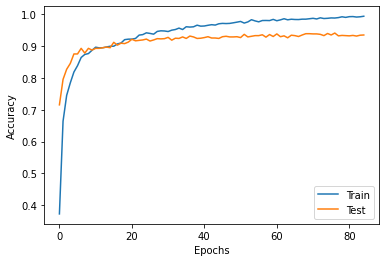

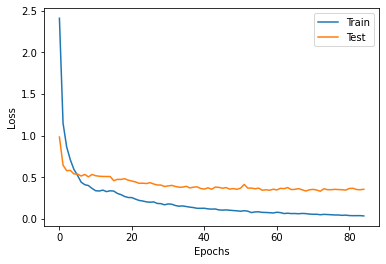

<AxesSubplot:>

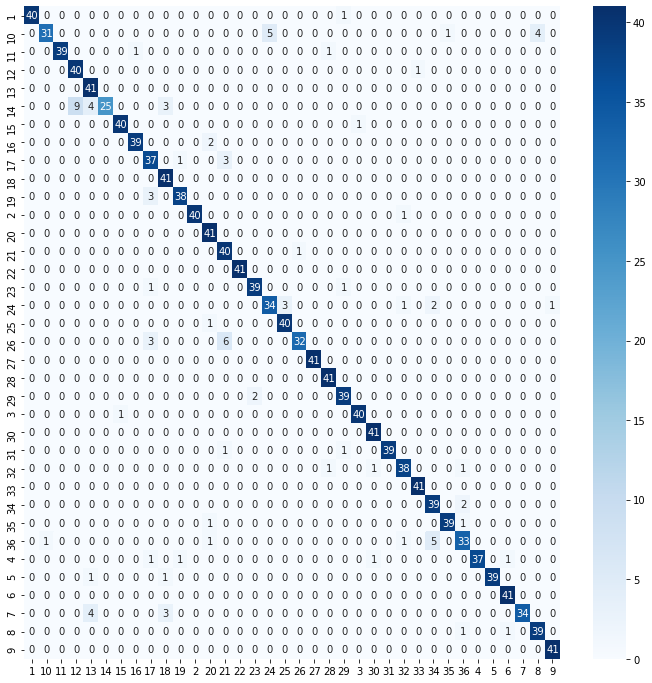

In [9]:
# HCR-Net (fine tuned network)
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import BatchNormalization as BatchNorm

# pre-trained models
from keras.applications.vgg16 import VGG16

# custom learning rates
import learning_rate as lr

# set the seeds for reproduceability (which is not certain in case of
# of multiple CPUs and GPU).
np.random.seed(1)
tf.random.set_seed(1)

# change following for each dataset (dataset details and learning params)
# dataset details
train_data_dir = './Data/Offline/NHCD/consonants/'
nb_train_samples = 5904
nb_validation_samples = 1476
num_classes = 36

# learning params
epochs1 = 10
epochs2 = 75
learning_rate1 = lr.decayed_learning_rate
learning_rate2 = lr.decayed_learning_rate_tuned75

batch_size = 32
# dimensions of our images.
img_width, img_height = 32, 32
input_shape = (img_width, img_height, 3)

# using VGG16: load model without classifier layer, and using weights from ImageNet
source_model = VGG16(include_top=False, input_shape=input_shape)

# create model
model = Sequential()

# add lower layers of VGG16 to our model, and mark as not trainable
for layer in source_model.layers[:-6]:
    layer.trainable = False
    model.add(layer)

# add extra layers at top of lower layers of pre-trained model
model.add(BatchNorm())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(512, activation='relu'))
model.add(BatchNorm())
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# using ImageDataGenerator to load and scale data
train_datagen = ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=10,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.1,
                    zoom_range=0.05,
                    fill_mode='constant',
                    cval = 0,
                    validation_split=0.2
                )
valid_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=17)
validation_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_validation_samples,
    color_mode="rgb",
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=17)

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate1)

history1 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs1,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)


# fine tuning the model by unfreezing the lower layers (used from VGG16)
for layer in model.layers[:12]:
    layer.trainable = True

# reset the image generators
train_generator.reset()
validation_generator.reset()

# recompile the model
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])
print(model.summary())

# define callback for custom learning rate
callback = tf.keras.callbacks.LearningRateScheduler(learning_rate2)

history2 = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs2,
    callbacks=[callback],
    validation_data=validation_generator,
    validation_steps=1)

# save model
# model.save_weights('HCR-Net.h5')

# plot the convergence, in terms of accuracy and loss, of HCR-Net
plt.plot(history1.history['accuracy']+history2.history['accuracy'])
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'])
# plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

plt.plot(history1.history['loss']+history2.history['loss'])
plt.plot(history1.history['val_loss']+history2.history['val_loss'])
# plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# evaluate model and plot confusion matrix
# filenames = validation_generator.filenames
predict = model.predict(validation_generator)
y_pred = np.argmax(predict,axis=-1)
cf_matrix = confusion_matrix(validation_generator.classes,y_pred)

# calculate size of confusion matrix figure, and plot it
fig, ax = plt.subplots(figsize=(math.ceil(num_classes/3.0), math.ceil(num_classes/3.0)))
labels = list(validation_generator.class_indices.keys())
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='', cmap='Blues')

In [10]:
print('precision_score: ', precision_score(validation_generator.classes,y_pred, average="macro"))
print('recall_score   : ', recall_score(validation_generator.classes,y_pred, average="macro"))
print('f1_score       : ', f1_score(validation_generator.classes,y_pred, average="macro"))
print('accuracy_score : ', accuracy_score(validation_generator.classes,y_pred, normalize=True))

print("\nBest accuracy  : ", max(max(history1.history['val_accuracy']), max(history2.history['val_accuracy'])))

precision_score:  0.9399556622401979
recall_score   :  0.9349593495934959
f1_score       :  0.9339318563807313
accuracy_score :  0.9349593495934959

Best accuracy  :  0.9410569071769714


Populating the interactive namespace from numpy and matplotlib
21 0
Predicted class: 29  actual class: 1/002_06.jpg 1


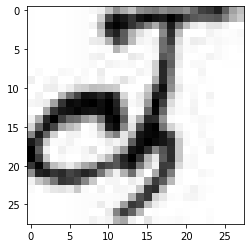

34 1
Predicted class: 8  actual class: 10/001_03.jpg 10


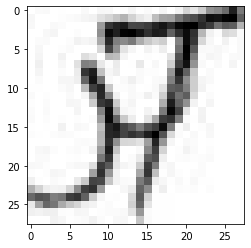

34 1
Predicted class: 8  actual class: 10/001_09.jpg 10


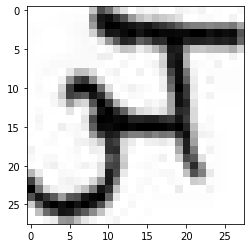

34 1
Predicted class: 8  actual class: 10/001_10.jpg 10


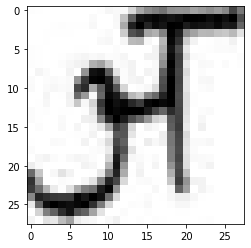

34 1
Predicted class: 8  actual class: 10/001_11.jpg 10


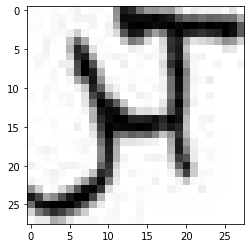

16 1
Predicted class: 24  actual class: 10/002_04.jpg 10


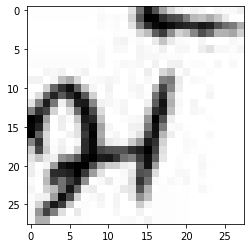

16 1
Predicted class: 24  actual class: 10/002_05.jpg 10


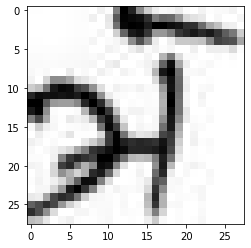

16 1
Predicted class: 24  actual class: 10/002_06.jpg 10


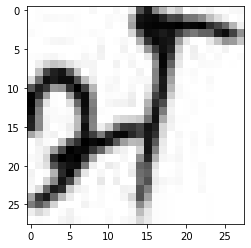

16 1
Predicted class: 24  actual class: 10/002_07.jpg 10


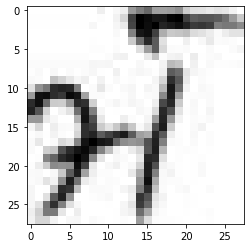

16 1
Predicted class: 24  actual class: 10/002_08.jpg 10


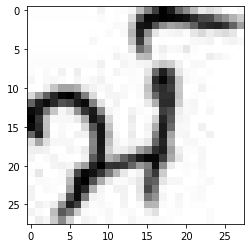

28 1
Predicted class: 35  actual class: 10/002_11.jpg 10


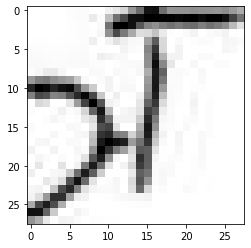

20 2
Predicted class: 28  actual class: 11/002_04.jpg 11


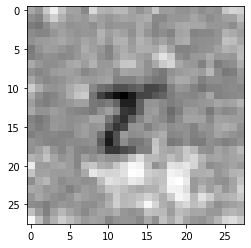

7 2
Predicted class: 16  actual class: 11/002_12.jpg 11


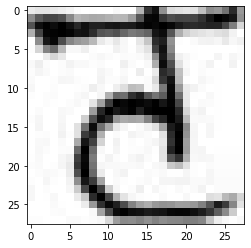

26 3
Predicted class: 33  actual class: 12/002_08.jpg 12


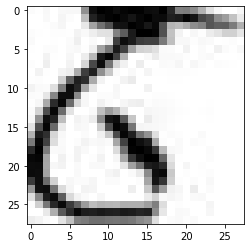

3 5
Predicted class: 12  actual class: 14/001_01.jpg 14


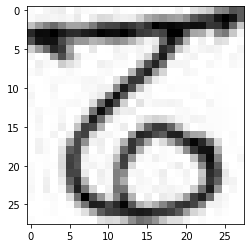

9 5
Predicted class: 18  actual class: 14/001_06.jpg 14


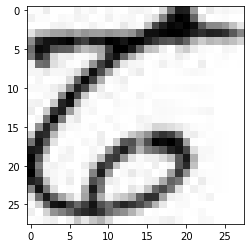

9 5
Predicted class: 18  actual class: 14/001_09.jpg 14


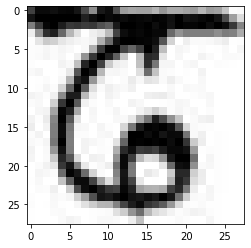

9 5
Predicted class: 18  actual class: 14/001_13.jpg 14


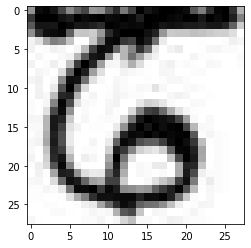

3 5
Predicted class: 12  actual class: 14/001_14.jpg 14


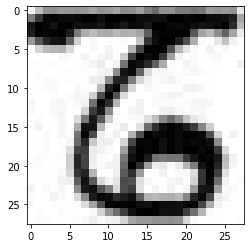

3 5
Predicted class: 12  actual class: 14/001_16.jpg 14


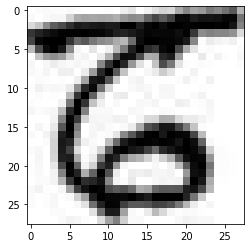

3 5
Predicted class: 12  actual class: 14/001_17.jpg 14


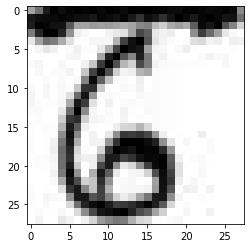

4 5
Predicted class: 13  actual class: 14/002_02.jpg 14


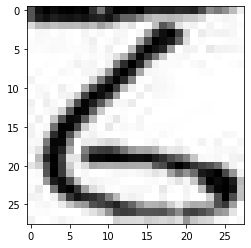

4 5
Predicted class: 13  actual class: 14/002_03.jpg 14


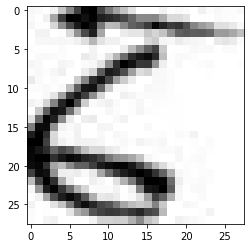

4 5
Predicted class: 13  actual class: 14/002_04.jpg 14


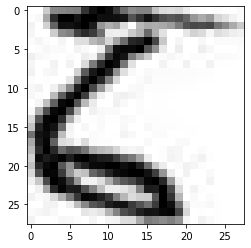

3 5
Predicted class: 12  actual class: 14/002_05.jpg 14


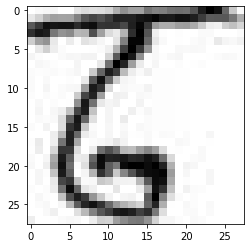

3 5
Predicted class: 12  actual class: 14/002_06.jpg 14


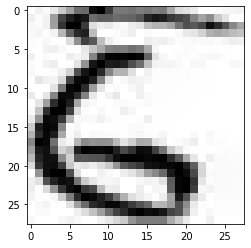

4 5
Predicted class: 13  actual class: 14/002_08.jpg 14


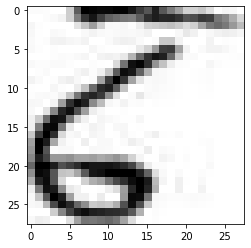

3 5
Predicted class: 12  actual class: 14/002_09.jpg 14


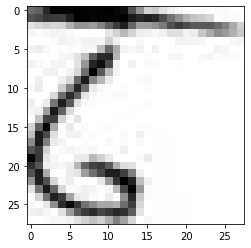

3 5
Predicted class: 12  actual class: 14/002_10.jpg 14


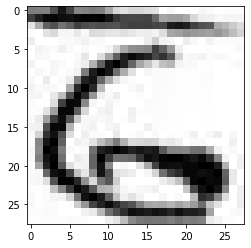

3 5
Predicted class: 12  actual class: 14/002_11.jpg 14


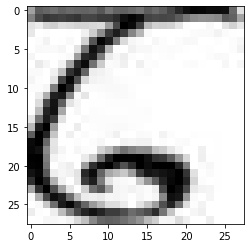

22 6
Predicted class: 3  actual class: 15/001_03.jpg 15


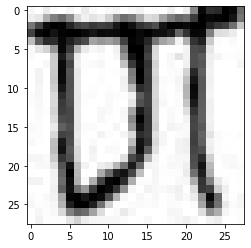

12 7
Predicted class: 20  actual class: 16/001_06.jpg 16


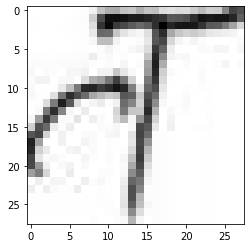

12 7
Predicted class: 20  actual class: 16/001_15.jpg 16


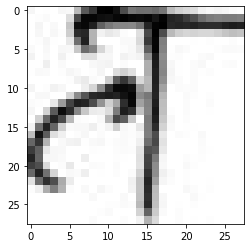

10 8
Predicted class: 19  actual class: 17/001_16.jpg 17


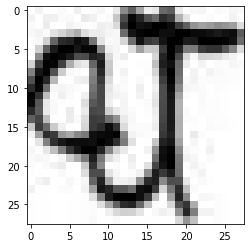

13 8
Predicted class: 21  actual class: 17/004_02.jpg 17


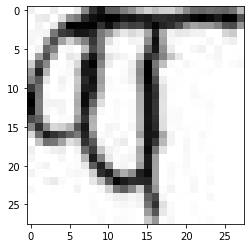

13 8
Predicted class: 21  actual class: 17/004_05.jpg 17


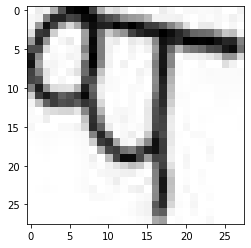

13 8
Predicted class: 21  actual class: 17/004_09.jpg 17


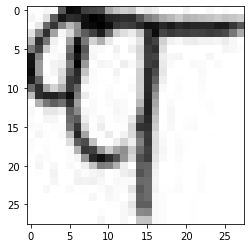

8 10
Predicted class: 17  actual class: 19/001_01.jpg 19


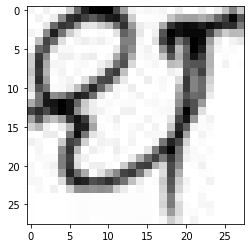

8 10
Predicted class: 17  actual class: 19/001_06.jpg 19


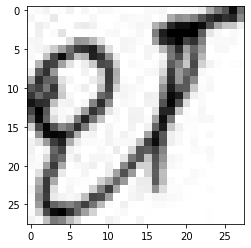

8 10
Predicted class: 17  actual class: 19/004_04.jpg 19


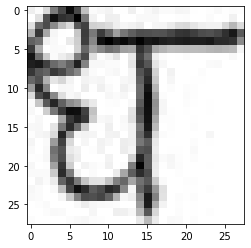

25 11
Predicted class: 32  actual class: 2/001_16.jpg 2


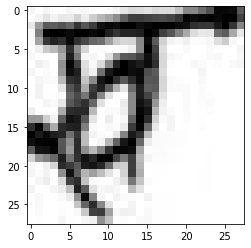

18 13
Predicted class: 26  actual class: 21/002_05.jpg 21


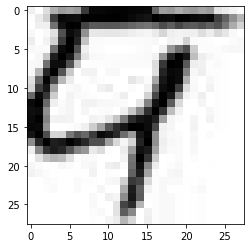

21 15
Predicted class: 29  actual class: 23/002_01.jpg 23


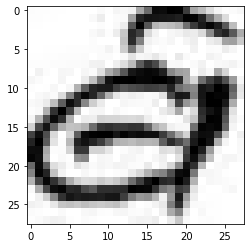

8 15
Predicted class: 17  actual class: 23/004_03.jpg 23


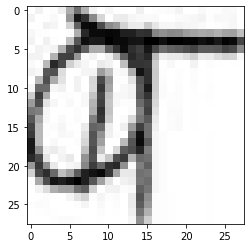

27 16
Predicted class: 34  actual class: 24/004_01.jpg 24


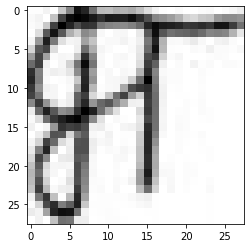

35 16
Predicted class: 9  actual class: 24/004_03.jpg 24


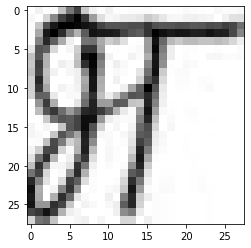

17 16
Predicted class: 25  actual class: 24/004_04.jpg 24


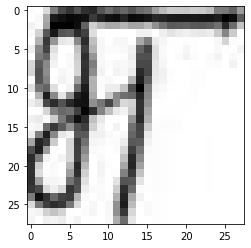

27 16
Predicted class: 34  actual class: 24/004_05.jpg 24


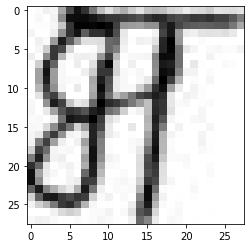

17 16
Predicted class: 25  actual class: 24/004_07.jpg 24


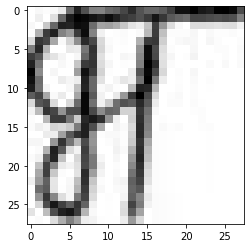

17 16
Predicted class: 25  actual class: 24/004_08.jpg 24


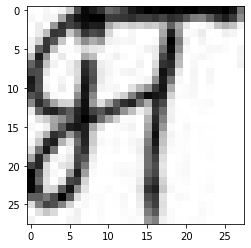

25 16
Predicted class: 32  actual class: 24/004_10.jpg 24


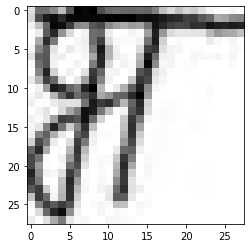

12 17
Predicted class: 20  actual class: 25/001_07.jpg 25


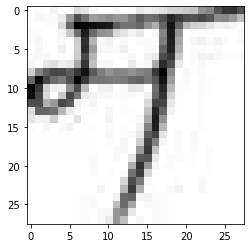

8 18
Predicted class: 17  actual class: 26/001_17.jpg 26


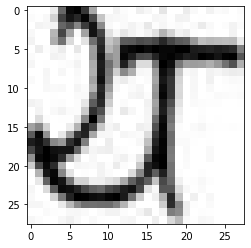

13 18
Predicted class: 21  actual class: 26/004_01.jpg 26


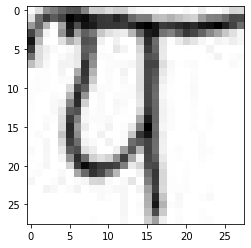

13 18
Predicted class: 21  actual class: 26/004_02.jpg 26


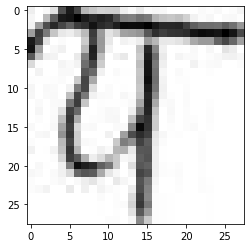

8 18
Predicted class: 17  actual class: 26/004_03.jpg 26


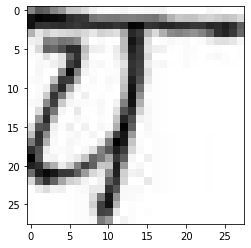

13 18
Predicted class: 21  actual class: 26/004_05.jpg 26


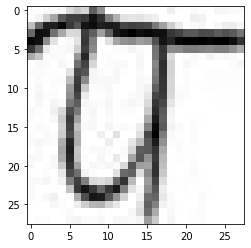

13 18
Predicted class: 21  actual class: 26/004_06.jpg 26


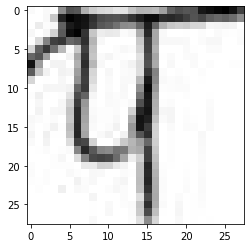

8 18
Predicted class: 17  actual class: 26/004_09.jpg 26


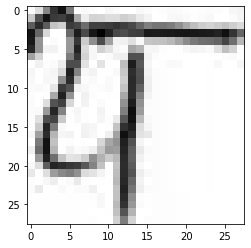

13 18
Predicted class: 21  actual class: 26/004_10.jpg 26


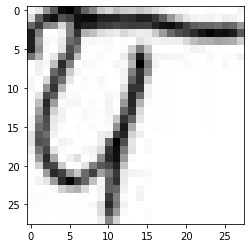

13 18
Predicted class: 21  actual class: 26/004_11.jpg 26


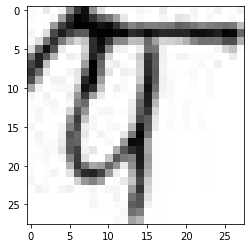

15 21
Predicted class: 23  actual class: 29/002_09.jpg 29


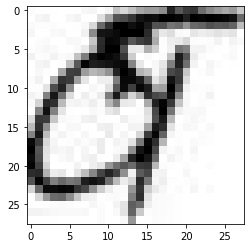

15 21
Predicted class: 23  actual class: 29/002_12.jpg 29


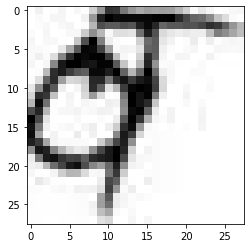

6 22
Predicted class: 15  actual class: 3/004_07.jpg 3


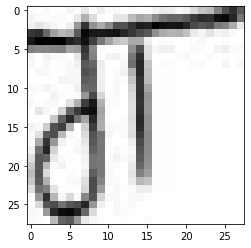

21 24
Predicted class: 29  actual class: 31/002_06.jpg 31


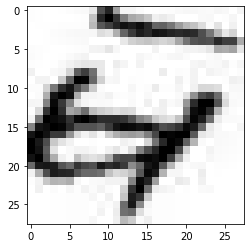

13 24
Predicted class: 21  actual class: 31/004_06.jpg 31


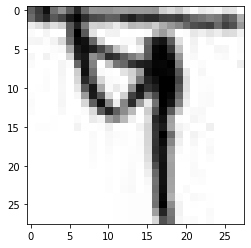

20 25
Predicted class: 28  actual class: 32/002_02.jpg 32


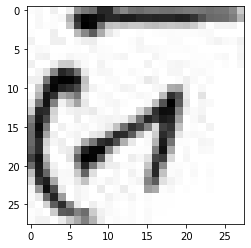

23 25
Predicted class: 30  actual class: 32/002_03.jpg 32


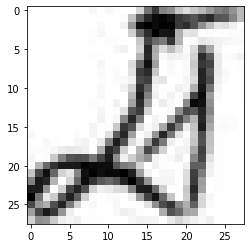

29 25
Predicted class: 36  actual class: 32/004_05.jpg 32


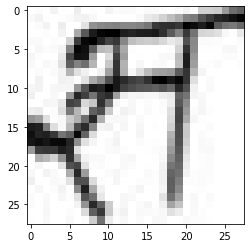

29 27
Predicted class: 36  actual class: 34/002_02.jpg 34


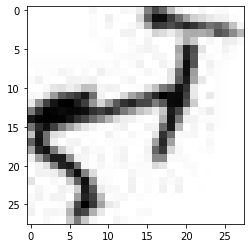

29 27
Predicted class: 36  actual class: 34/002_09.jpg 34


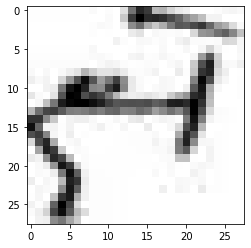

29 28
Predicted class: 36  actual class: 35/001_02.jpg 35


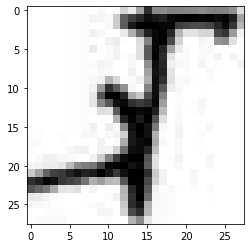

12 28
Predicted class: 20  actual class: 35/002_13.jpg 35


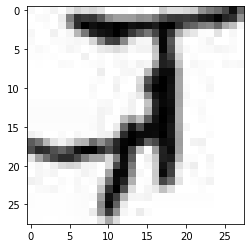

27 29
Predicted class: 34  actual class: 36/001_01.jpg 36


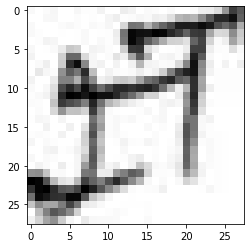

27 29
Predicted class: 34  actual class: 36/001_02.jpg 36


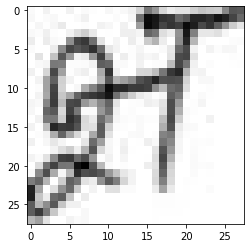

27 29
Predicted class: 34  actual class: 36/001_03.jpg 36


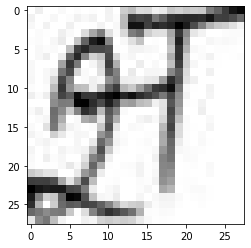

27 29
Predicted class: 34  actual class: 36/001_04.jpg 36


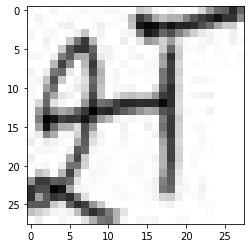

27 29
Predicted class: 34  actual class: 36/001_07.jpg 36


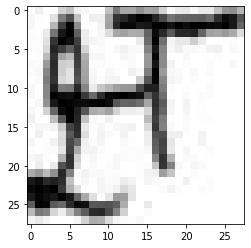

25 29
Predicted class: 32  actual class: 36/001_08.jpg 36


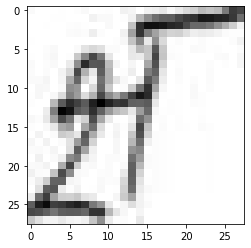

12 29
Predicted class: 20  actual class: 36/001_09.jpg 36


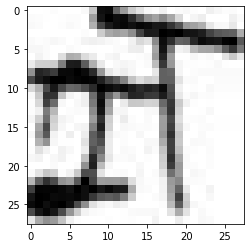

1 29
Predicted class: 10  actual class: 36/001_11.jpg 36


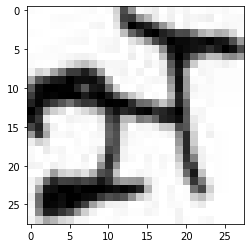

23 30
Predicted class: 30  actual class: 4/001_03.jpg 4


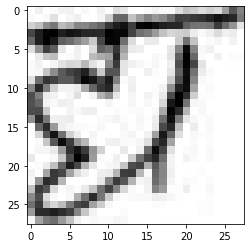

32 30
Predicted class: 6  actual class: 4/002_03.jpg 4


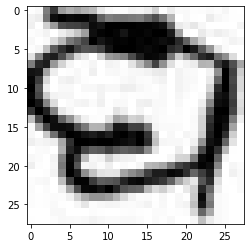

10 30
Predicted class: 19  actual class: 4/002_06.jpg 4


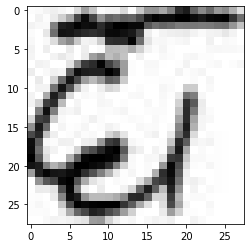

8 30
Predicted class: 17  actual class: 4/002_11.jpg 4


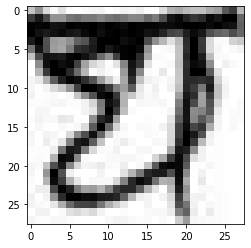

4 31
Predicted class: 13  actual class: 5/002_02.jpg 5


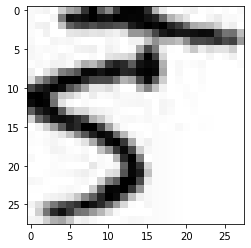

9 31
Predicted class: 18  actual class: 5/004_04.jpg 5


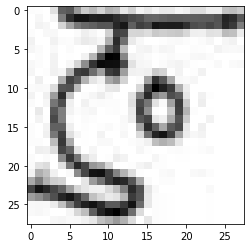

9 33
Predicted class: 18  actual class: 7/001_01.jpg 7


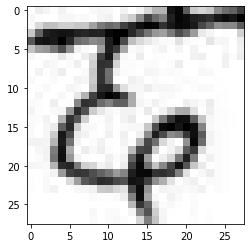

4 33
Predicted class: 13  actual class: 7/002_04.jpg 7


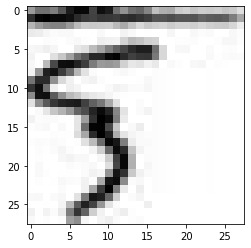

4 33
Predicted class: 13  actual class: 7/002_06.jpg 7


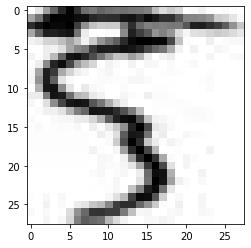

4 33
Predicted class: 13  actual class: 7/002_07.jpg 7


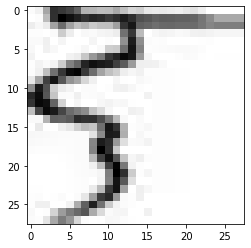

4 33
Predicted class: 13  actual class: 7/002_08.jpg 7


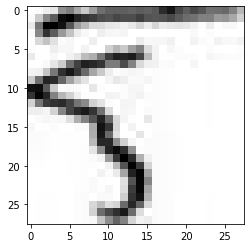

9 33
Predicted class: 18  actual class: 7/004_04.jpg 7


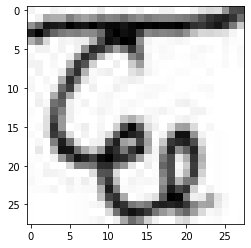

9 33
Predicted class: 18  actual class: 7/004_06.jpg 7


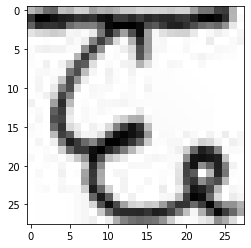

32 34
Predicted class: 6  actual class: 8/002_08.jpg 8


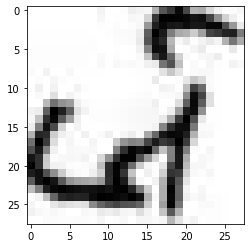

29 34
Predicted class: 36  actual class: 8/004_06.jpg 8


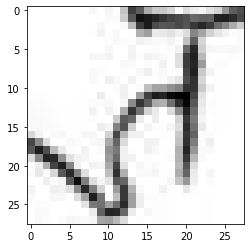

In [12]:
# miss-classification analysis
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

test_folder = './Data/Offline/NHCD/consonants/'

image_names = validation_generator.filenames
image_classes = validation_generator.classes
class_dict = validation_generator.class_indices
class_dict = dict((v,k) for k,v in class_dict.items())

image_predicted = y_pred

for i in range(len(image_predicted)):
    if image_predicted[i] != image_classes[i]:
        print(image_predicted[i], image_classes[i])
        print('Predicted class:', class_dict[image_predicted[i]], ' actual class:', image_names[i], class_dict[image_classes[i]])
        img = mpimg.imread(test_folder + image_names[i])
        imgplot = plt.imshow(img, cmap='gray')
        plt.show()
#         break;